# Currency Hedging
Assume that an EUR based investor is investing in EUR and US equities and EUR and
USD denominated zero coupon bonds. The investor has a one year investment horizon.
The investor’s objective is to find the optimal portfolio when allowing hedging of the USD
exposure. The hedging will be performed using one year FX forward contracts that allows
the investor to buy or sell one USD at a pre-specified price in one year.

The market is assumed to be driven by a set of market invariants:

\
\begin{align*}
\Delta X_t = \left(\begin{array}{c}
\Delta \log FX_t \\
\Delta \log V_t^{US,local} \\
\Delta \log V_t^{EUR} \\
\Delta y_t^{EUR,1/12} \\
\Delta y_t^{EUR,1} \\
\Delta y_t^{EUR,3} \\
\Delta y_t^{EUR,5} \\
\Delta y_t^{EUR,7} \\
\Delta y_t^{EUR,10} \\
\Delta y_t^{USD,1/12} \\
\Delta y_t^{USD,1} \\
\Delta y_t^{USD,3} \\
\Delta y_t^{USD,5} \\
\Delta y_t^{USD,7} \\
\Delta y_t^{USD,10}
\end{array}\right)
\end{align*}

The time step is assumed to be one week or 1/52 years. $FX_t$ denotes the EUR/USD exchange rate, the number of USD required to buy one EUR, $\log V_t^{US,local}$ denotes the value of US equities measured in USD, $\log V_t^{EUR}$ denotes the value of EUR equities measured in EUR, $y_t^{x,\tau}$ is the $\tau$ year continuously compounded zero coupon yield for the $x$ economy. The whole USD and EUR yield curve is spanned by these two set of zero coupon yields. The yields for any given time to maturity can be obtained by linear interpolation.

The market invariants are normally distributed

$$
\Delta X_t \sim \mathcal{N}(\mu, \Sigma)
$$

The covariance matrix is provided in the file `covariance_matrix.xlsx`. The vector of expectations is given by $\mu = (0, 0.07 \cdot \Delta t, 0.06 \cdot \Delta t, 0^T,0^T)^T$.

## Loading packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Data.Data import covariance_matrix, init_values, cov_matrix, x0, mean_vector, delta_t
from scipy.stats import norm, lognorm
import seaborn as sns

## Question 1
Assume that we are standing at time $t = 0$ with initial values, $x_0$, as specified in `init_values.xlsx`. What is the distribution of $X_1$? Simulate the evolution of $X_t$ with weekly time steps from time zero to the horizon. Visualize the evolution of $\log F{X_t}$.


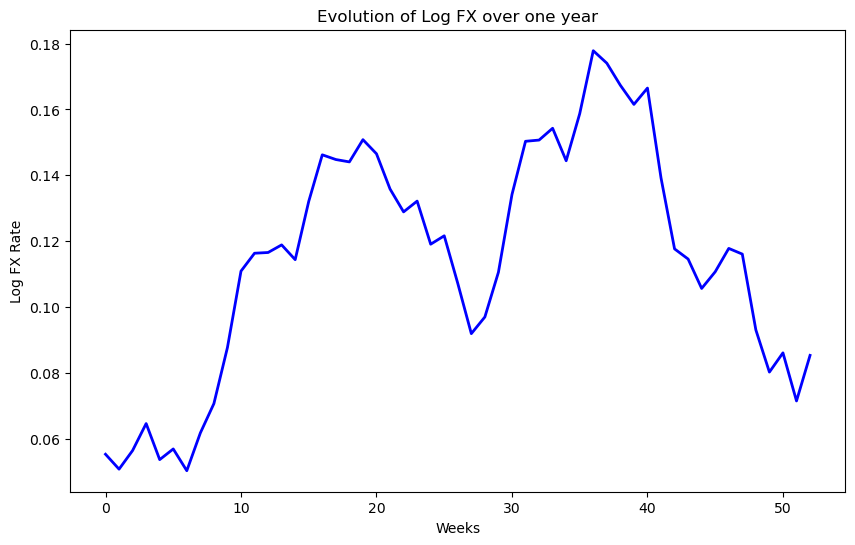

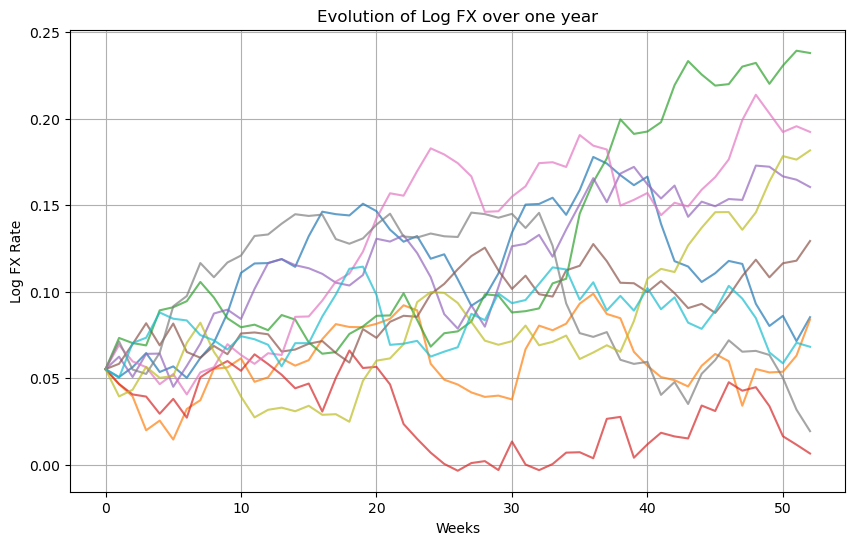

In [2]:
# Simulation parameters
time_horizon = 52  # Weekly steps (1 year)
num_simulations = 10000  # Number of paths

# Simulating X_t evolution
np.random.seed(42)  # For reproducibility
simulations = np.zeros((time_horizon + 1, len(x0), num_simulations))
simulations[0] = x0[:, None]  # Set initial values

for t in range(1, time_horizon + 1):
    # Generate random shocks
    shocks = np.random.multivariate_normal(mean_vector, cov_matrix, num_simulations).T
    # Update simulations for time t
    simulations[t] = simulations[t - 1] + shocks

# Extract log FX evolution
log_fx_simulations = simulations[:, 0, :]  # log(FX_t) is the first variable



# Define the time points (from 0 to 52 weeks)
time_points = range(time_horizon + 1)

# Plot the first simulation path
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(time_points, log_fx_simulations[:, 0], label='Simulation 1', linewidth=2, color='blue')
# Adding labels and title
plt.title('Evolution of Log FX over one year')
plt.xlabel('Weeks')
plt.ylabel('Log FX Rate')
# Show the plot
plt.show()



# Visualize the evolution of log(FX_t)
plt.figure(figsize=(10, 6))
for i in range(min(10, num_simulations)):  # Plot first 10 paths
    plt.plot(range(time_horizon + 1), log_fx_simulations[:, i], alpha=0.7)
plt.title("Evolution of Log FX over one year")
plt.xlabel("Weeks")
plt.ylabel("Log FX Rate")
plt.grid(True)
plt.show()

## Question 2
Obtain the distribution of $V_{1}^{US,local}$. Again, simulate the evolution of $V_{1}^{US,local}$. Compare the simulated data with the true analytical distribution.


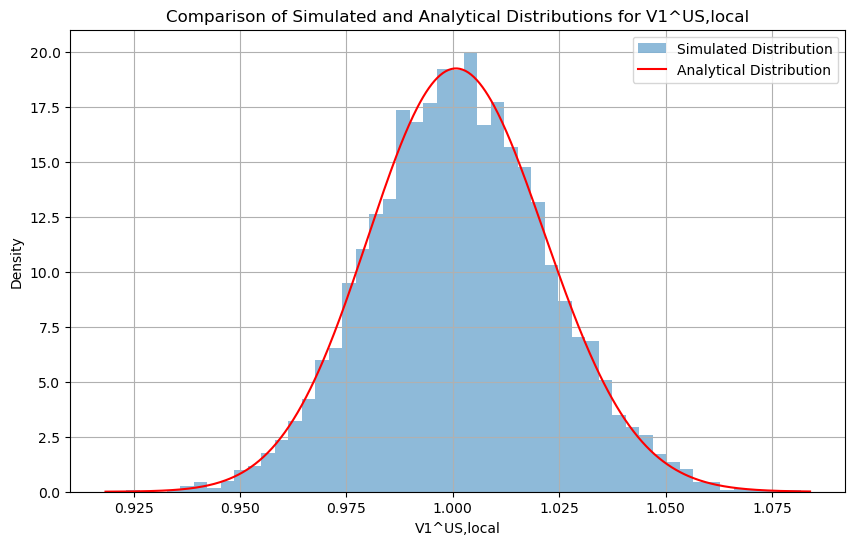

In [9]:
# Parameters and simulation setup
v_us_index = 1
mean_vector = np.array([0.07 * delta_t, 0.06 * delta_t] + [0] * (len(covariance_matrix) - 2))
num_simulations = 10000

#Simulate the distribution of V1^US,local
np.random.seed(42)
simulated_shocks = np.random.multivariate_normal(mean_vector, cov_matrix, num_simulations)
#simulated_v1_us_local = x0[v_us_index] + simulated_shocks[:, v_us_index]
simulated_v1_us_local = np.exp(x0[v_us_index] + simulated_shocks[:, v_us_index])

# Analytical distribution of V1^US,local
#mean_v1_us_local = x0[v_us_index] + mean_vector[v_us_index]
mean_v1_us_local = np.exp(x0[v_us_index] + mean_vector[v_us_index])
std_v1_us_local = np.sqrt(cov_matrix[v_us_index, v_us_index])

# Plot the simulated and analytical distributions
plt.figure(figsize=(10, 6))

# Simulated distribution
plt.hist(simulated_v1_us_local, bins=50, alpha=0.5, label="Simulated Distribution", density=True)

# Analytical normal distribution
x = np.linspace(mean_v1_us_local - 4 * std_v1_us_local, mean_v1_us_local + 4 * std_v1_us_local, 500) #generates the linearly spaced numbers over which the PDF will be calculated.
#pdf = norm.pdf(x, loc=mean_v1_us_local, scale=std_v1_us_local) #calculates the PDF
pdf = lognorm.pdf(x, s=std_v1_us_local, scale=mean_v1_us_local)
plt.plot(x, pdf, label="Analytical Distribution", color='red')

# Labels and legend
plt.title("Comparison of Simulated and Analytical Distributions for V1^US,local")
plt.xlabel("V1^US,local")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()



## Question 3
Explain how to calculate the value of a EUR or USD zero coupon bond based on the vector of yields at a given point in time. What is the distribution of an initial 5 year zero coupon at the horizon? Simulate the evolution of the initial 5 year zero coupon bond. Compare the simulated data with the true analytical distribution.


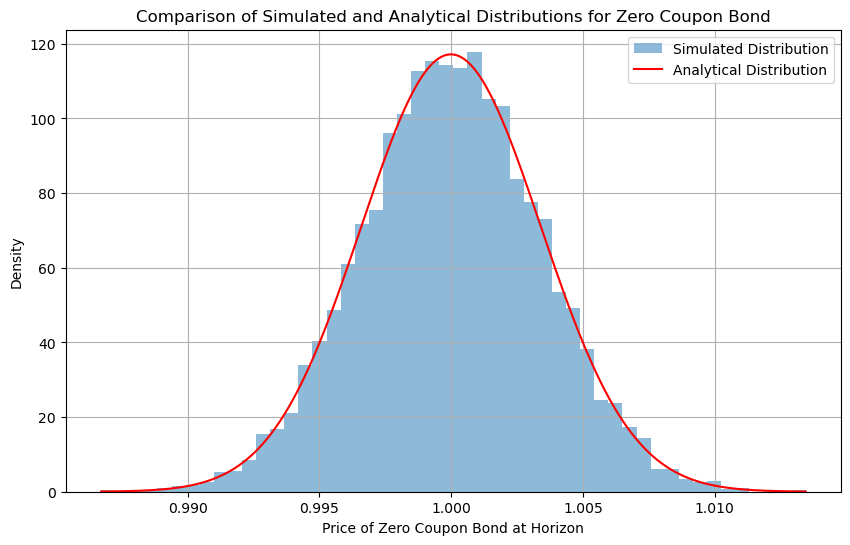

In [4]:
# Parameters
initial_yield_index = 6  # Assuming the 5-year yield is at index 4 in the state vector
tau_initial = 5  # Initial maturity
tau_horizon = 4  # Maturity at horizon
num_simulations = 10000

# Initial values and parameters
initial_yield = x0[initial_yield_index]
mu_yield = mean_vector[initial_yield_index]
sigma_yield = np.sqrt(cov_matrix[initial_yield_index, initial_yield_index])

# Simulate weekly changes in yield
np.random.seed(42)
simulated_yields = np.random.normal(mu_yield, sigma_yield, size=num_simulations)

# Calculate bond prices at horizon
prices_horizon = np.exp(-simulated_yields * tau_horizon)

# Analytical distribution parameters
mu_price = -tau_horizon * mu_yield
sigma_price = np.sqrt(tau_horizon**2 * sigma_yield**2)

# Plot simulated and analytical distributions
plt.figure(figsize=(10, 6))

# Simulated distribution
plt.hist(prices_horizon, bins=50, alpha=0.5, label="Simulated Distribution", density=True)

# Analytical lognormal distribution
x = np.linspace(min(prices_horizon), max(prices_horizon), 500)
pdf = lognorm.pdf(x, s=sigma_price, scale=np.exp(mu_price))
plt.plot(x, pdf, label="Analytical Distribution", color='red')

# Labels and legend
plt.title("Comparison of Simulated and Analytical Distributions for Zero Coupon Bond")
plt.xlabel("Price of Zero Coupon Bond at Horizon")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## Question 4
What is the joint distribution of the vector $P_1 = (F{X_1}, V_{1}^{US,local}, V_{1}^{EUR}, Z_{1}^{USD 4Y,local}, Z_{1}^{EUR 4Y})^T$? Here $Z_{1}^{USD 4Y,local}$ denotes a 4 year USD zero coupon bond such the investor initially has bought a 5 year zero coupon bond.


In [4]:
# Given parameters
X0 = x0
mu = mean_vector
Sigma = cov_matrix
time_steps = 52  # Number of weekly time steps

# Calculate mean and covariance matrix of X1
mean_X1 = X0 + time_steps * mu
cov_X1 = time_steps * Sigma

# Define indices for P1 components in X1
log_FX_index = 0
log_V_US_index = 1
log_V_EUR_index = 2
y_US_3_index = 11
y_US_5_index = 12
y_EUR_3_index = 5
y_EUR_5_index = 6

# Analytical transformations for P1 components
# Mean and variance of lognormal variables are derived from the normal distribution of X1
mean_log_FX = mean_X1[log_FX_index]
var_log_FX = cov_X1[log_FX_index, log_FX_index]

mean_log_V_US = mean_X1[log_V_US_index]
var_log_V_US = cov_X1[log_V_US_index, log_V_US_index]

mean_log_V_EUR = mean_X1[log_V_EUR_index]
var_log_V_EUR = cov_X1[log_V_EUR_index, log_V_EUR_index]

# Interpolation for yields to calculate bond prices
mean_y_US_4 = mean_X1[y_US_3_index] + (4 - 3) / (5 - 3) * (mean_X1[y_US_5_index] - mean_X1[y_US_3_index])
var_y_US_4 = (
    (4 - 3) / (5 - 3) ** 2 * cov_X1[y_US_5_index, y_US_5_index]
    + cov_X1[y_US_3_index, y_US_3_index]
    - 2 * (4 - 3) / (5 - 3) * cov_X1[y_US_3_index, y_US_5_index]
)

mean_y_EUR_4 = mean_X1[y_EUR_3_index] + (4 - 3) / (5 - 3) * (mean_X1[y_EUR_5_index] - mean_X1[y_EUR_3_index])
var_y_EUR_4 = (
    (4 - 3) / (5 - 3) ** 2 * cov_X1[y_EUR_5_index, y_EUR_5_index]
    + cov_X1[y_EUR_3_index, y_EUR_3_index]
    - 2 * (4 - 3) / (5 - 3) * cov_X1[y_EUR_3_index, y_EUR_5_index]
)

# Mean and variance for lognormal bond prices
mean_Z_US_4Y = -mean_y_US_4 * 4
var_Z_US_4Y = (4 ** 2) * var_y_US_4

mean_Z_EUR_4Y = -mean_y_EUR_4 * 4
var_Z_EUR_4Y = (4 ** 2) * var_y_EUR_4

# Jacobian matrix for transformations
J = np.zeros((5, len(X0)))

# Fill Jacobian entries for each transformation
# FX_1 = exp(log FX)
J[0, log_FX_index] = np.exp(mean_log_FX)

# V1_US = exp(log V_US)
J[1, log_V_US_index] = np.exp(mean_log_V_US)

# V1_EUR = exp(log V_EUR)
J[2, log_V_EUR_index] = np.exp(mean_log_V_EUR)

# Z1_US_4Y = exp(-y_US_4 * 4)
J[3, y_US_3_index] = -4 * (1 - (4 - 3) / (5 - 3)) * np.exp(mean_Z_US_4Y)
J[3, y_US_5_index] = -4 * (4 - 3) / (5 - 3) * np.exp(mean_Z_US_4Y)

# Z1_EUR_4Y = exp(-y_EUR_4 * 4)
J[4, y_EUR_3_index] = -4 * (1 - (4 - 3) / (5 - 3)) * np.exp(mean_Z_EUR_4Y)
J[4, y_EUR_5_index] = -4 * (4 - 3) / (5 - 3) * np.exp(mean_Z_EUR_4Y)

# Covariance matrix of P1
cov_P1 = J @ cov_X1 @ J.T

# Output mean vector and covariance matrix of P1
mean_P1 = np.array([
    np.exp(mean_log_FX),
    np.exp(mean_log_V_US),
    np.exp(mean_log_V_EUR),
    np.exp(mean_Z_US_4Y),
    np.exp(mean_Z_EUR_4Y),
])

## Question 5
What is the distribution of the vector $P_{1}^{EUR} = (\frac{1}{F{X_1}}, V_{1}^{US}, V_{1}^{EUR}, Z_{1}^{USD 4Y}, Z_{1}^{EUR 4Y})^T$ where all values are in EUR? Compare the simulated data with the true analytical distribution for $V_{1}^{US}$.


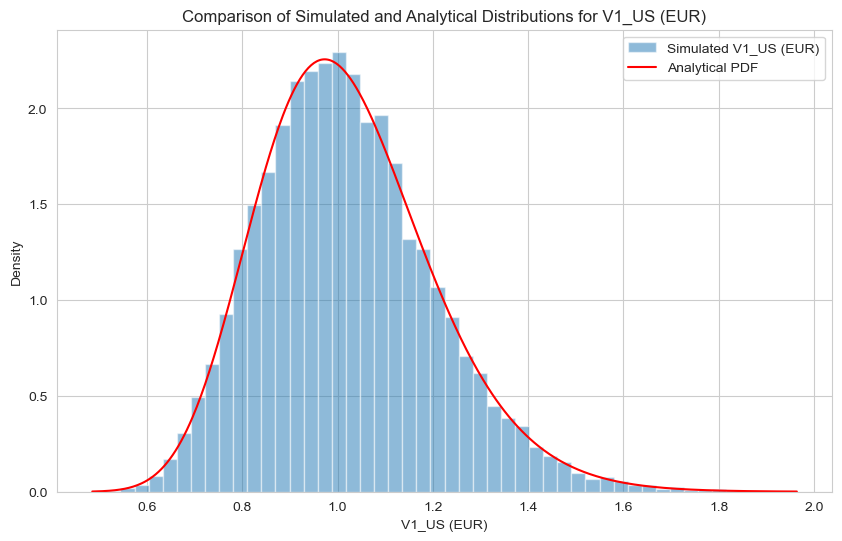

In [5]:
# Mean and variance for P1^{EUR}
# Reciprocal FX
mean_1_FX = np.exp(-mean_log_FX + var_log_FX)
var_1_FX = (np.exp(var_log_FX) - 1) * np.exp(-2 * mean_log_FX + var_log_FX)

# V1_US in EUR
mean_V1_US_EUR = np.exp(mean_log_V_US) * mean_1_FX
var_V1_US_EUR = (np.exp(var_log_V_US) - 1) * np.exp(2 * mean_log_V_US + var_log_V_US) + var_1_FX * mean_V1_US_EUR**2

# Z1_US_4Y in EUR
mean_Z1_US_4Y_EUR = np.exp(mean_Z_US_4Y) * mean_1_FX
var_Z1_US_4Y_EUR = (np.exp(var_Z_US_4Y) - 1) * np.exp(2 * mean_Z_US_4Y + var_Z_US_4Y) + var_1_FX * mean_Z1_US_4Y_EUR**2

# Analytical approximations for lognormal PDF
sigma_V1_US_EUR = np.sqrt(var_V1_US_EUR)
mu_V1_US_EUR = np.log(mean_V1_US_EUR) - 0.5 * sigma_V1_US_EUR**2


# Plot comparison between simulation and analytical PDF
# Simulated data (placeholder for demonstration)
V1_US_EUR_simulated = np.random.lognormal(mean=mu_V1_US_EUR, sigma=sigma_V1_US_EUR, size=10000)

plt.figure(figsize=(10, 6))

# Simulated histogram
plt.hist(V1_US_EUR_simulated, bins=50, density=True, alpha=0.5, label='Simulated V1_US (EUR)')

# Analytical PDF
x = np.linspace(min(V1_US_EUR_simulated), max(V1_US_EUR_simulated), 500)
pdf = lognorm.pdf(x, s=sigma_V1_US_EUR, scale=np.exp(mu_V1_US_EUR))
plt.plot(x, pdf, label='Analytical PDF', color='red')

# Labels and legend
plt.title('Comparison of Simulated and Analytical Distributions for V1_US (EUR)')
plt.xlabel('V1_US (EUR)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

## Question 6
The one year FX forward price is given by

$$
F_0^1 = F{X_0} e^{1\cdot(y_{0}^{USD,1} - y_{0}^{EUR,1})}
$$

which is the exchange rate (the price of one EUR in USD) that the investor can lock in at time zero.

The investor can choose a 5 x 1 holding vector **$h$** which defines the number of units in each asset / instrument. The first instrument is a FX forward that gives the investor the right and obligation to sell 1 unit of USD for the price $1/F_0^1$ in one year while the remaining assets are the ones discussed above. Note that the forward contract has a value of zero initially. The portfolio PnL of the investor is given by the product of the holding vector and the vector of PnLs

$$
PnL_1 = {\bf h^T PnL_1}
$$

where

$$
{\bf PnL_1} = \begin{pmatrix}
\frac{1}{F_0^1} - \frac{1}{F_{X_1}} \\
V_{1}^{US} - V_{0}^{US} \\
V_{1}^{EUR} - V_{0}^{EUR} \\
Z_{1}^{USD 4Y} - Z_{0}^{USD 5Y} \\
Z_{1}^{EUR 4Y} - Z_{0}^{EUR 5Y}
\end{pmatrix}
$$



How could we calculate the expectation and the covariance matrix of the PnL vector? What is the distribution of the PnL vector? Can we derive the distribution of the PnL of the portfolio? What is the expectation and variance of the portfolio PnL?




PnL Vector Mean:
 [0.01731776 0.00146369 0.00044173 0.01835567 0.03218226]
PnL Vector Covariance:
 [[ 3.50370398e-08 -7.78360087e-07  9.84836874e-08 -2.52556742e-08
  -1.93801164e-07]
 [-7.78360087e-07  4.63371063e-04  3.66659955e-04  7.53339809e-06
  -1.16743398e-05]
 [ 9.84836874e-08  3.66659955e-04  4.85968148e-04  3.31847963e-06
  -1.49809261e-05]
 [-2.52556742e-08  7.53339809e-06  3.31847963e-06  9.43028322e-06
   7.37680929e-06]
 [-1.93801164e-07 -1.16743398e-05 -1.49809261e-05  7.37680929e-06
   1.26422712e-05]]
Portfolio PnL Mean: 0.00908897255158783
Portfolio PnL Variance: 0.0001506196628647507


## Question 7
The optimal number of FX forward contracts, $h_1$, to minimize the PnL variance for a fixed allocation to the remaining assets $h_2$ ($h = (h_1, h_2^T)^T$) is given by

$$
h_1 = \frac{-\Sigma^{PnL}_{12} h_2}{\Sigma^{PnL}_{11}}
$$

where

$$
\Sigma_{PnL} = \begin{pmatrix}
\Sigma^{PnL}_{11} & \Sigma^{PnL}_{12} \\
\Sigma^{PnL}_{21} & \Sigma^{PnL}_{22}
\end{pmatrix}
$$



Define the hedge ratio as the amount USD hedged (the number of forward contracts) relative to the amount of USD invested. Consider three different portfolios: One that invests 1 EUR in US equities, one that invests 1 EUR in 5 year USD zero coupon bond and one that invests 0.2 EUR in both US and EUR equities and 0.3 EUR in both EUR and USD zero coupon bonds. For the three portfolios plot the combinations of standard deviation and expected PnL for hedge ratios ranging from -1 to 1.5. Calculate the optimal hedge ratios for each portfolio and add their standard deviation and expected PnL to the plots. What do you observe?


## Question 8
For the multi-asset portfolio, describe how to find the minimum 5% CVaR hedge ratio. Plot the combinations of 5% CVaR and expected PnL for hedge ratios ranging from -1 to 1.5. What do you observe?


## Question 9
For the multi-asset portfolio, describe how to perform a simulation study that examines the effect of estimation uncertainty from estimating $\Sigma$ using the sample covariance matrix while keeping $\mu$ fixed. Consider a two year sample of the market invariants. Based on simulated covariance matrices, calculate optimal hedge ratios. Evaluate the simulated optimal hedge ratios using the true distributional parameters to visualize the resulting distributions of expected PnL, standard deviation, 5% CVaR, etc.


## Question 10
The investor is considering different portfolio optimization strategies for setting both the optimal asset weights and the optimal hedge ratio. The three possibilities are:

- Mean-Variance portfolio optimization using pre-specified hedge ratios equal to the asset specific optimal (minimum-variance) hedge ratios.
- Initial Mean-Variance portfolio optimization with a hedge ratio constrained to zero followed by choosing the hedge ratio as the minimum-variance hedge ratio.
- Full scale Mean-Variance portfolio optimization that allows the hedge ratio to be calculated directly.

Implement the three portfolio optimization strategies. A non-shorting constraint is imposed for the four assets, but not the forward contract. The investor has a budget of 1 EUR. For each strategy, the efficient frontier needs to be calculated for all possible PnL targets from the smallest to the largest. Present relevant visualizations and discuss your results.


## Question 11
Perform a simulation study that examines the effect of estimation uncertainty from estimating $\Sigma$ using the sample covariance matrix while keeping $\mu$ fixed for the three strategies (consider only one or two portfolios on the efficient frontier, e.g., the minimum-variance portfolio). Present and discuss relevant results.
